Dataset shape: (1470, 35)

Column types:
 Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLe

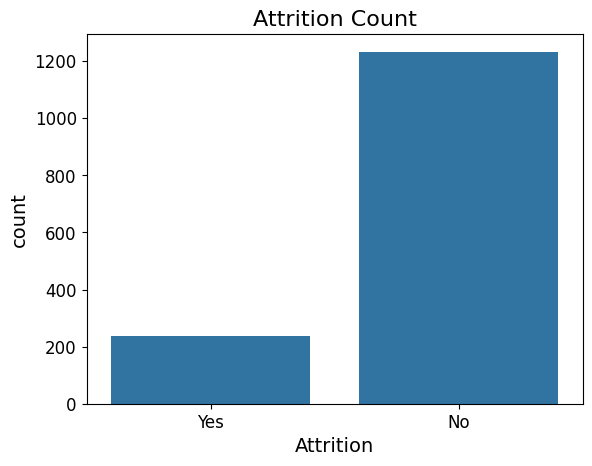

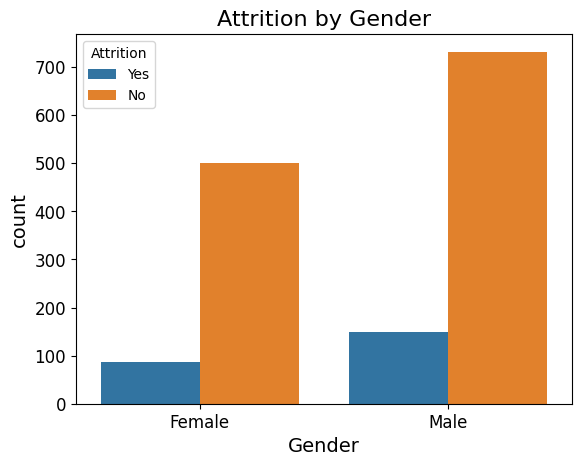

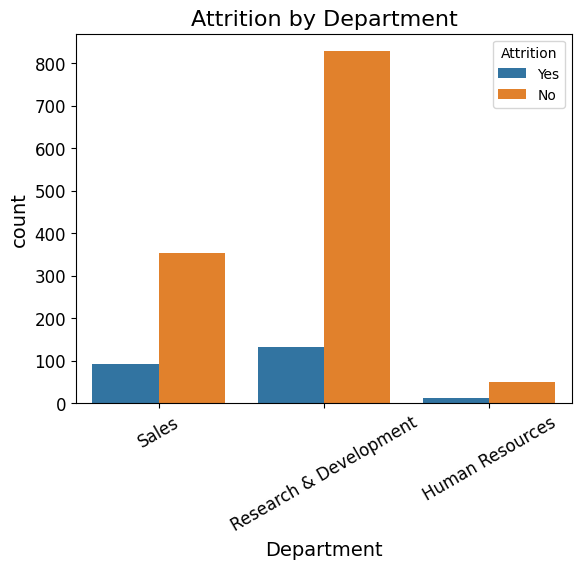

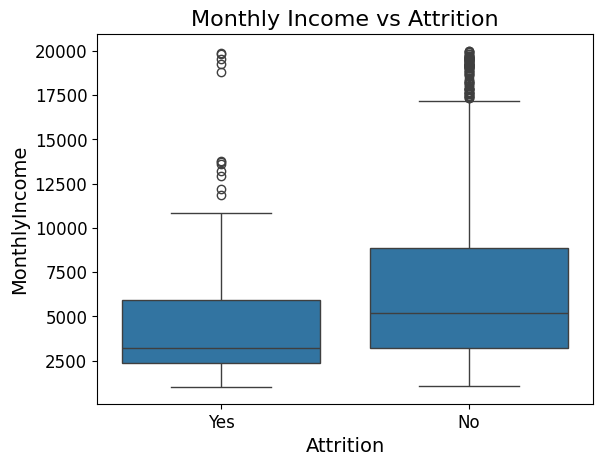

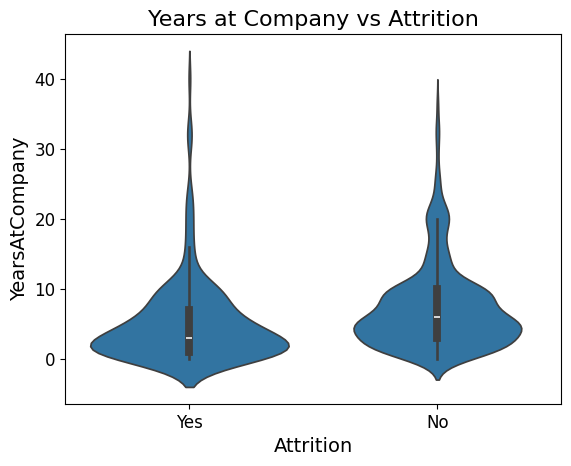

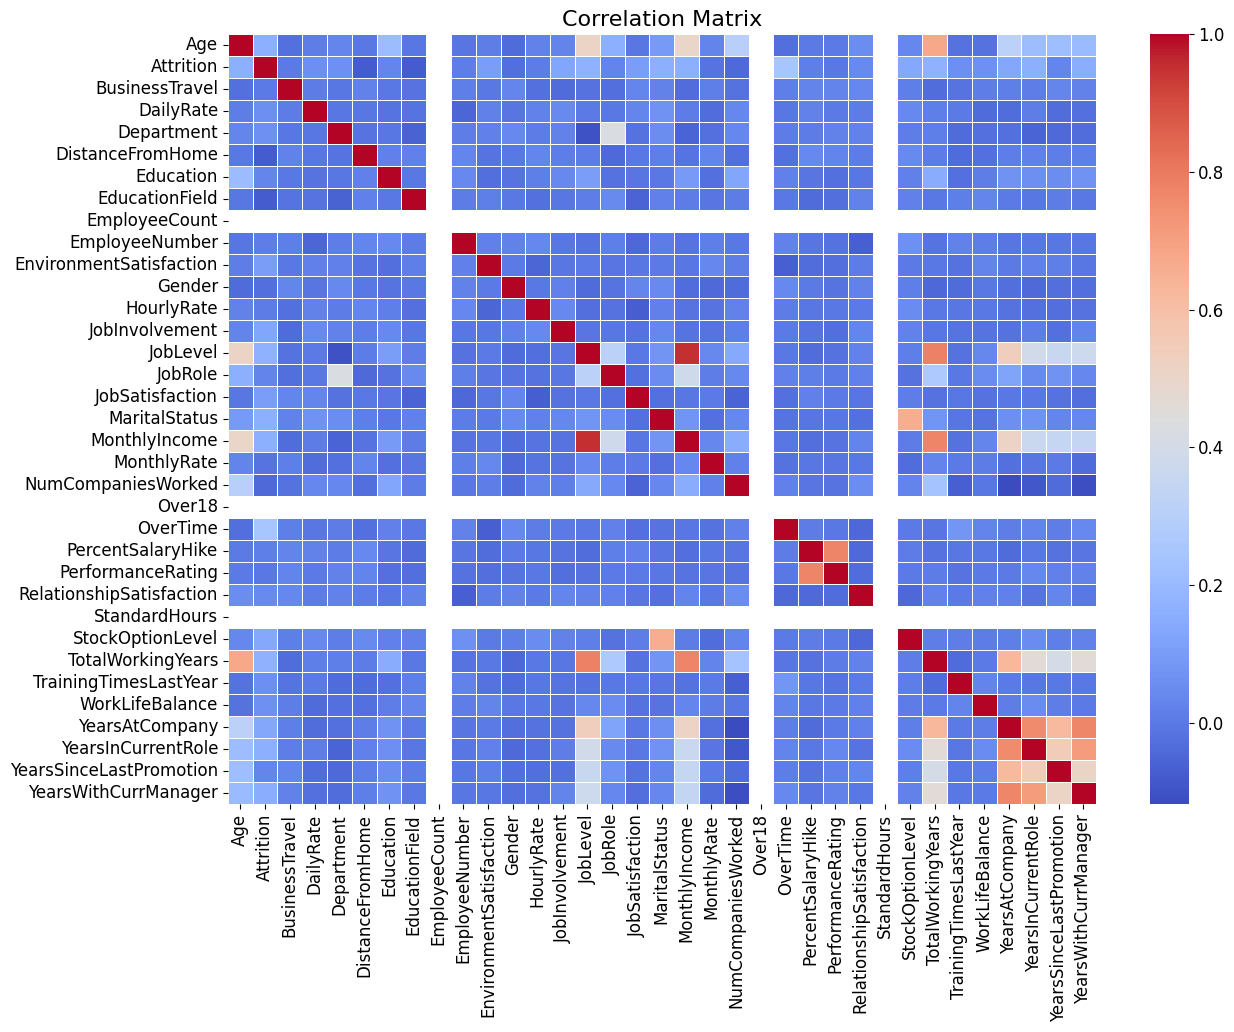


Top correlations with Attrition:
 Attrition               1.000000
OverTime                0.246118
TotalWorkingYears       0.171063
JobLevel                0.169105
MaritalStatus           0.162070
YearsInCurrentRole      0.160545
MonthlyIncome           0.159840
Age                     0.159205
YearsWithCurrManager    0.156199
StockOptionLevel        0.137145
Name: Attrition, dtype: float64

Negative correlations with Attrition:
 BusinessTravel        0.000074
PerformanceRating    -0.002889
MonthlyRate          -0.015170
Gender               -0.029453
NumCompaniesWorked   -0.043494
EducationField       -0.075437
DistanceFromHome     -0.077924
EmployeeCount              NaN
Over18                     NaN
StandardHours              NaN
Name: Attrition, dtype: float64


In [7]:
## --Catherine Holsten Project Summer 2025--##
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Basic Information
print("Dataset shape:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nSummary statistics (numerical):\n", df.describe())
print("\nSummary statistics (categorical):\n", df.describe(include='object'))

# Attrition Overview
print("\nAttrition counts:\n", df['Attrition'].value_counts())
print("\nAttrition percentage:\n", df['Attrition'].value_counts(normalize=True) * 100)

# Mean tenure for Attrition = Yes
mean_tenure_yes = df[df['Attrition'] == 'Yes']['YearsAtCompany'].mean()
print(f"\nMean YearsAtCompany for employees who left: {mean_tenure_yes:.2f} years")

# Visualizations

# Attrition count plot
sns.countplot(data=df, x='Attrition')
plt.title("Attrition Count")
plt.show()

# Attrition by Gender
sns.countplot(data=df, x='Gender', hue='Attrition')
plt.title("Attrition by Gender")
plt.show()

# Attrition by Department
sns.countplot(data=df, x='Department', hue='Attrition')
plt.title("Attrition by Department")
plt.xticks(rotation=30)
plt.show()

# Boxplot: Monthly Income by Attrition
sns.boxplot(data=df, x='Attrition', y='MonthlyIncome')
plt.title("Monthly Income vs Attrition")
plt.show()

# Violin plot: YearsAtCompany by Attrition
sns.violinplot(data=df, x='Attrition', y='YearsAtCompany')
plt.title("Years at Company vs Attrition")
plt.show()

# Correlation Analysis

# Convert categorical to numeric for correlation matrix
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include='object').columns
df_encoded[categorical_cols] = df_encoded[categorical_cols].apply(lambda x: pd.factorize(x)[0])

# Correlation matrix
corr = df_encoded.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Top correlations with Attrition
top_corr = corr['Attrition'].sort_values(ascending=False)
print("\nTop correlations with Attrition:\n", top_corr.head(10))
print("\nNegative correlations with Attrition:\n", top_corr.tail(10))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:10:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Chosen threshold: 0.55 (Recall ≥ 0.50)

Classification Report (Custom Threshold):
               precision    recall  f1-score   support

           0       0.91      0.88      0.89       247
           1       0.46      0.55      0.50        47

    accuracy                           0.83       294
   macro avg       0.69      0.72      0.70       294
weighted avg       0.84      0.83      0.83       294

Confusion Matrix (Custom Threshold):
 [[217  30]
 [ 21  26]]

Top 10 Important Features:
 TotalWorkingYears          0.097883
JobLevel                   0.076372
YearsAtCompany             0.072345
OverTime                   0.067630
YearsWithCurrManager       0.063244
StockOptionLevel           0.061891
Age                        0.044651
EnvironmentSatisfaction    0.037431
JobRole                    0.036512
NumCompaniesWorked         0.036474
dtype: float32

Generating SHAP values...

Mean absolute SHAP value per feature (global impact):
OverTime                   0.440885
StockOp

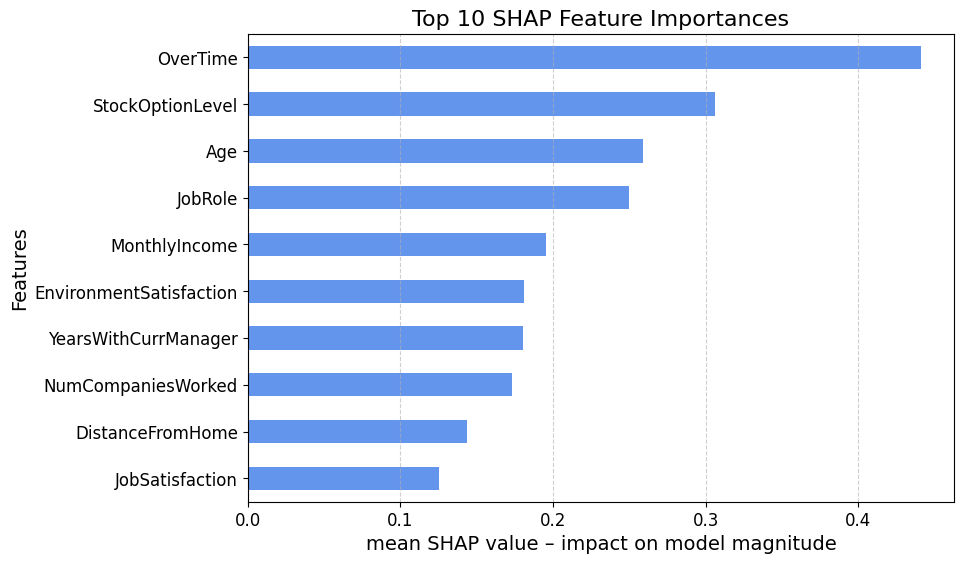

JobRole Encoding Mapping:
Healthcare Representative → 0
Human Resources → 1
Laboratory Technician → 2
Manager → 3
Manufacturing Director → 4
Research Director → 5
Research Scientist → 6
Sales Executive → 7
Sales Representative → 8


In [3]:
# XGBoost + SHAP
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import shap

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Drop irrelevant columns
drop_cols = ['EmployeeNumber', 'EmployeeCount', 'MonthlyRate', 'Over18', 'StandardHours', 'JobInvolvement', 'HourlyRate']
df.drop(columns=drop_cols, inplace=True)

# Encode categorical variables
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Define features and target
X = df_encoded.drop(columns='Attrition')
y = df_encoded['Attrition']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Compute scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and tune XGBoost
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(
    xgb, param_grid, scoring='recall', cv=5, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Predict probabilities
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Tune threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Trim recall and precision to match thresholds length
recall = recall[:-1]
precision = precision[:-1]

# Filter to keep only thresholds where recall >= 0.50
valid = recall >= 0.50
if np.any(valid):
    best_idx = np.argmax(precision[valid])
    optimal_threshold = thresholds[valid][best_idx]
    print(f"Chosen threshold: {optimal_threshold:.2f} (Recall ≥ 0.50)")
else:
    optimal_threshold = 0.5  # fallback
    print("No threshold found with recall >= 0.50, using default threshold of 0.5")

# Predict with custom threshold
y_pred_custom = (y_proba >= optimal_threshold).astype(int)
print("\nClassification Report (Custom Threshold):\n", classification_report(y_test, y_pred_custom))
print("Confusion Matrix (Custom Threshold):\n", confusion_matrix(y_test, y_pred_custom))

# Feature importances
importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
print("\nTop 10 Important Features:\n", importances.sort_values(ascending=False).head(10))

# SHAP Explanation
print("\nGenerating SHAP values...")

# Compute SHAP values
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)

# Compute mean absolute SHAP value per feature
shap_summary = shap_df.abs().mean().sort_values(ascending=False)
print("\nMean absolute SHAP value per feature (global impact):")
print(shap_summary.head(10))

# Compute mean absolute SHAP values
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_summary = shap_df.abs().mean().sort_values(ascending=False)

# Select top 10 features
top_10_features = shap_summary.head(10)

# Plot
plt.figure(figsize=(10, 6))
top_10_features[::-1].plot(kind='barh', color='cornflowerblue')

# Customize layout and labels
plt.title("Top 10 SHAP Feature Importances", fontsize=16)
plt.xlabel("mean SHAP value – impact on model magnitude", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=2.0)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


# Check JobRole mapping
jobrole_encoder = label_encoders['JobRole']
jobrole_mapping = dict(zip(jobrole_encoder.classes_, jobrole_encoder.transform(jobrole_encoder.classes_)))
print("JobRole Encoding Mapping:")
for role, code in jobrole_mapping.items():
    print(f"{role} → {code}")


<Figure size 1200x600 with 0 Axes>

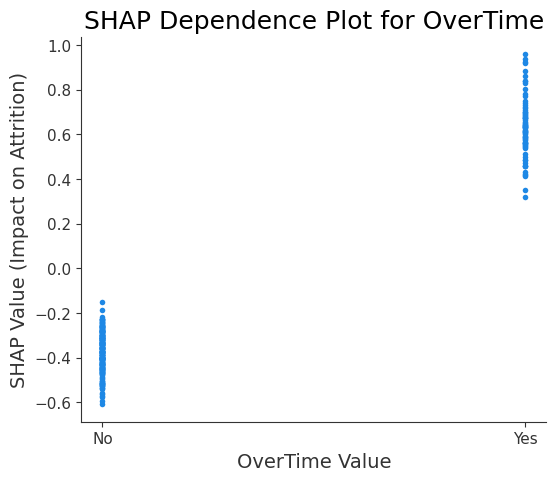

<Figure size 1200x600 with 0 Axes>

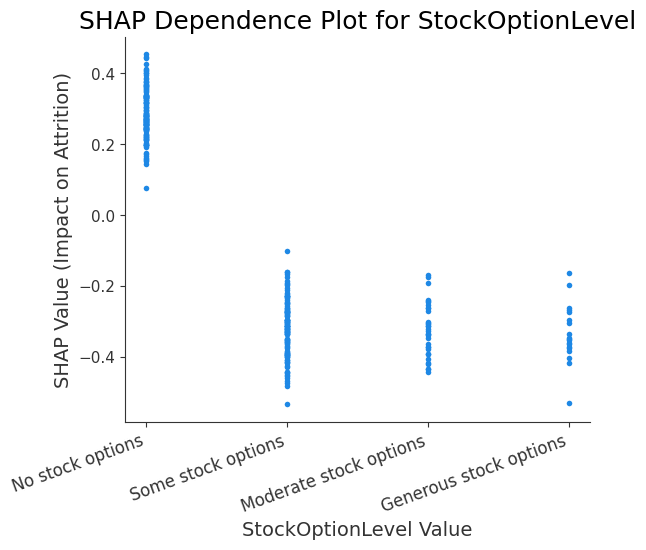

<Figure size 1200x600 with 0 Axes>

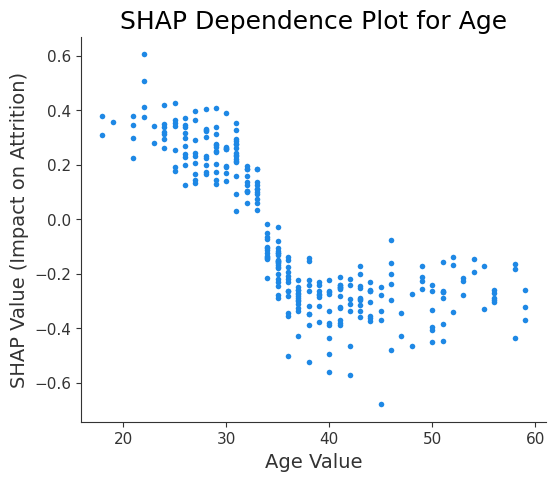

<Figure size 1200x600 with 0 Axes>

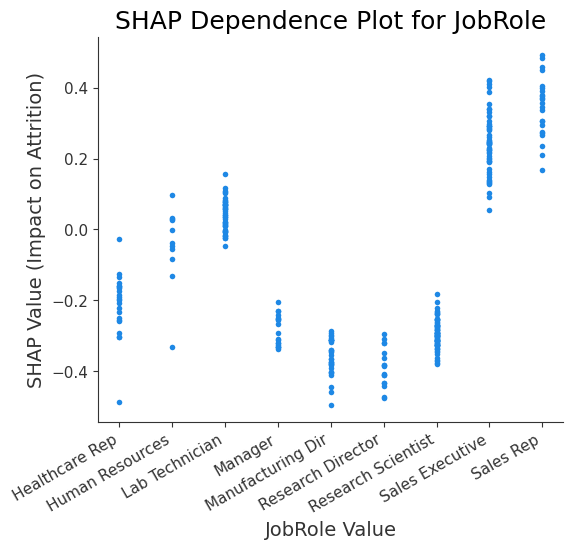

<Figure size 1200x600 with 0 Axes>

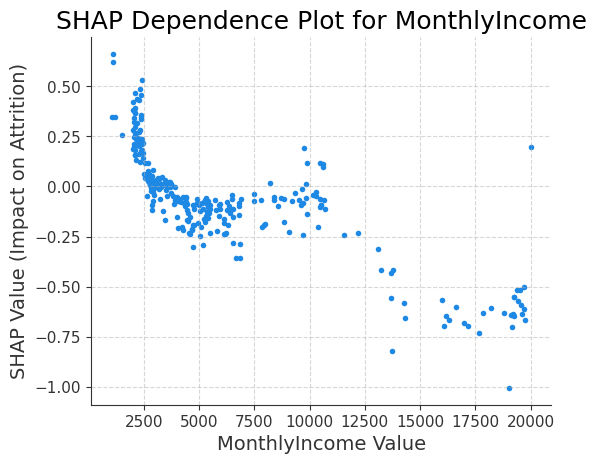

In [4]:
import matplotlib.pyplot as plt
import shap

# Mapping dictionaries for categorical features
overtime_labels = {0: 'No', 1: 'Yes'}
stock_option_labels = {
    0: 'No stock options',
    1: 'Some stock options',
    2: 'Moderate stock options',
    3: 'Generous stock options'
}
jobrole_labels = {
    0: 'Healthcare Rep',
    1: 'Human Resources',
    2: 'Lab Technician',
    3: 'Manager',
    4: 'Manufacturing Dir',
    5: 'Research Director',
    6: 'Research Scientist',
    7: 'Sales Executive',
    8: 'Sales Rep'
}

# Define features to plot
features_to_plot = ['OverTime', 'StockOptionLevel', 'Age', 'JobRole', 'MonthlyIncome']

# Set larger plot styles
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Plot each feature
for feature in features_to_plot:
    plt.figure(figsize=(12, 6))
    shap.dependence_plot(
        feature, shap_values, X_test, show=False, interaction_index=None
    )

    # Custom title and x-labels
    title = f"SHAP Dependence Plot for {feature}"
    plt.title(title, fontsize=18)
    plt.xlabel(f"{feature} Value", fontsize=14)
    plt.ylabel("SHAP Value (Impact on Attrition)", fontsize=14)


    # Replace x-ticks for encoded categorical features
    if feature == 'OverTime':
        plt.xticks(ticks=list(overtime_labels.keys()),
                   labels=list(overtime_labels.values()))
    elif feature == 'StockOptionLevel':
        plt.xticks(
    ticks=list(stock_option_labels.keys()),
    labels=list(stock_option_labels.values()),
    rotation=20,  # adjust angle
    ha='right',   # align right
    fontsize=12
)
    elif feature == 'JobRole':
        plt.xticks(ticks=list(jobrole_labels.keys()),
                   labels=list(jobrole_labels.values()), rotation=30, ha='right')

plt.tight_layout(pad=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [5]:
# Decision tree model comparison
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")  # Ensure this file is in your working directory

# Drop unnecessary columns
columns_to_exclude = [
    'EmployeeNumber', 'EmployeeCount', 'MonthlyRate',
    'Over18', 'HourlyRate', 'StandardHours', 'JobInvolvement'
]
df.drop(columns=columns_to_exclude, inplace=True)

# Encode categorical variables
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Define features (X) and target (y)
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluation metrics
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       247
           1       0.33      0.36      0.35        47

    accuracy                           0.78       294
   macro avg       0.60      0.61      0.61       294
weighted avg       0.79      0.78      0.79       294


=== Confusion Matrix ===
[[213  34]
 [ 30  17]]


In [6]:
# Logistic regression model comparison
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Columns to exclude
exclude_columns = [
    'EmployeeNumber', 'EmployeeCount', 'MonthlyRate', 'Over18',
    'HourlyRate', 'StandardHours', 'JobInvolvement'
]

# Drop excluded columns
df = df.drop(columns=exclude_columns, errors='ignore')

# Encode categorical variables
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include='object'):
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Define features (X) and target (y)
X = df_encoded.drop(columns='Attrition')
y = df_encoded['Attrition']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = log_reg.predict(X_test)

# Print results
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.97      0.92       247
           1       0.67      0.34      0.45        47

    accuracy                           0.87       294
   macro avg       0.78      0.65      0.69       294
weighted avg       0.85      0.87      0.85       294


=== Confusion Matrix ===
[[239   8]
 [ 31  16]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
